In [1]:
!mkdir results

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
import time
from copy import deepcopy # Add Deepcopy for args
import seaborn as sns 
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
partition = {'train': trainset, 'val':valset, 'test':testset}

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hid_dim, n_layer, act, dropout, use_bn, use_xavier):
        super(MLP, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hid_dim = hid_dim
        self.n_layer = n_layer
        self.act = act
        self.dropout = dropout
        self.use_bn = use_bn
        self.use_xavier = use_xavier
        
        # ====== Create Linear Layers ====== #
        self.fc1 = nn.Linear(self.in_dim, self.hid_dim)
        
        self.linears = nn.ModuleList()
        self.bns = nn.ModuleList()
        for i in range(self.n_layer-1):
            self.linears.append(nn.Linear(self.hid_dim, self.hid_dim))
            if self.use_bn:
                self.bns.append(nn.BatchNorm1d(self.hid_dim))
                
        self.fc2 = nn.Linear(self.hid_dim, self.out_dim)
        
        # ====== Create Activation Function ====== #
        if self.act == 'relu':
            self.act = nn.ReLU()
        elif self.act == 'tanh':
            self.act == nn.Tanh()
        elif self.act == 'sigmoid':
            self.act = nn.Sigmoid()
        else:
            raise ValueError('no valid activation function selected!')
        
        # ====== Create Regularization Layer ======= #
        self.dropout = nn.Dropout(self.dropout)
        if self.use_xavier:
            self.xavier_init()

    def forward(self, x):
        x = self.act(self.fc1(x))
        for i in range(len(self.linears)):
            x = self.act(self.linears[i](x))
            x = self.bns[i](x)
            x = self.dropout(x)
        x = self.fc2(x)
        return x
    
    def xavier_init(self):
        for linear in self.linears:
            nn.init.xavier_normal_(linear.weight)
            linear.bias.data.fill_(0.01)
            
net = MLP(3072, 10, 100, 4, 'relu', 0.1, True, True) # Testing Model Construction

In [5]:
cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 
          512, 512, 512, 512, 'M'],
}

In [6]:
class VGG(nn.Module):
    
    def __init__(self, model_code, in_channels, out_dim, act, use_bn):
        super(VGG, self).__init__()
        
        if act == 'relu':
            self.act = nn.ReLU()
        elif act == 'sigmoid':
            self.sigmoid = nn.Sigmoid()
        elif act =='tanh':
            self.act = nn.Tanh()
        else:
            raise ValueError("Not a valid activation function code")
        
        
        self.layers = self._make_layers(model_code, in_channels, batch_norm=use_bn)
        self.classifier = nn.Sequential(nn.Linear(512, 256),
                                        nn.ReLU(),
                                        nn.Linear(256, out_dim))

    def forward(self, x):
        x = self.layers(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    
    
    def _make_layers(self, model_code, in_channels, batch_norm=False):
        layers = []
        for v in cfg[model_code]:
            if v == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels=in_channels, 
                                     out_channels=v, 
                                     kernel_size=3, 
                                     padding=1)]
                
                if batch_norm:
                    layers += [nn.BatchNorm2d(v)]
                layers += [self.act]
                in_channels = v
        return nn.Sequential(*layers)

In [7]:
class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, 
                               out_channels=64, 
                               kernel_size=3, 
                               stride=1, 
                               padding=1)
        self.conv2 = nn.Conv2d(in_channels=64,
                              out_channels=256,
                              kernel_size=5,
                              stride=1,
                              padding=2)
        self.act = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2,
                                    stride=2)
        self.fc = nn.Linear(65536, 10)
    
    def forward(self, x):
        x = self.act(self.conv1(x))
        x = self.act(self.conv2(x))
        x = self.maxpool1(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [8]:
def dim_check():
    net = VGG('A', 3, out_dim=10, act='relu', use_bn=True)
    x = torch.randn(2, 3, 32, 32)
    y = net.forward(x)
    print(y.size())
dim_check()

torch.Size([2, 10])


In [9]:
def train(net, partition, optimizer, criterion, args):
    trainloader = torch.utils.data.DataLoader(partition['train'], 
                                              batch_size=args.train_batch_size, 
                                              shuffle=True, num_workers=2)
    net.train()

    correct = 0
    total = 0
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        optimizer.zero_grad() # [21.01.05 오류 수정] 매 Epoch 마다 .zero_grad()가 실행되는 것을 매 iteration 마다 실행되도록 수정했습니다. 

        # get the inputs
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = train_loss / len(trainloader)
    train_acc = 100 * correct / total
    return net, train_loss, train_acc

In [10]:
def validate(net, partition, criterion, args):
    valloader = torch.utils.data.DataLoader(partition['val'], 
                                            batch_size=args.test_batch_size, 
                                            shuffle=False, num_workers=2)
    net.eval()

    correct = 0
    total = 0
    val_loss = 0 
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            outputs = net(images)

            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(valloader)
        val_acc = 100 * correct / total
    return val_loss, val_acc

In [11]:
def test(net, partition, args):
    testloader = torch.utils.data.DataLoader(partition['test'], 
                                             batch_size=args.test_batch_size, 
                                             shuffle=False, num_workers=2)
    net.eval()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
    return test_acc

In [12]:
def experiment(partition, args):  
    net = VGG(model_code=args.model_code, in_channels=args.in_channels,
             out_dim=args.out_dim,
             act=args.act,
             use_bn=args.use_bn)
    net.cuda()

    criterion = nn.CrossEntropyLoss()
    if args.optim == 'SGD':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')
    
    # ===== List for epoch-wise data ====== #
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    # ===================================== #
        
    for epoch in tqdm(range(args.epoch)):  # loop over the dataset multiple times
        ts = time.time()
        net, train_loss, train_acc = train(net, partition, optimizer, criterion, args)
        val_loss, val_acc = validate(net, partition, criterion, args)
        te = time.time()
        
        # ====== Add Epoch Data ====== #
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        # ============================ #
        
        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.2f}/{:2.2f}. Took {:2.2f} sec'.format(epoch, train_acc, val_acc, train_loss, val_loss, te-ts))
        
    test_acc = test(net, partition, args)    
    
    # ======= Add Result to Dictionary ======= #
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    # vars() : args => dict
    return vars(args), result
    # ===================================== #

In [13]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    
    # 달라져도 서로 다른 파일이 생기는 것을 원하지 않을 때
    del setting['epoch']
    del setting['test_batch_size']

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = './results/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting)    # dict를 합치기 위해서
    with open(filename, 'w') as f:
        json.dump(result, f)

    
def load_exp_result(exp_name):
    dir_path = './results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result) # .drop(columns=[])
    return df

In [14]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp1_lr_model_code"

# ====== Model Capacity ====== #
args.model_code = 'A'
args.in_channels = 3
args.out_dim = 10
args.act = 'relu'

# ====== Regularization ======= #
args.l2 = 0.00001
args.use_bn = True

# ====== Optimizer & Training ====== #
args.optim = 'RMSprop' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.0015
args.epoch = 10

args.train_batch_size = 1024
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'lr'
name_var2 = 'model_code'
list_var1 = [0.0001, 0.00001]
list_var2 = ['A']


for var1 in list_var1:
    for var2 in list_var2:
        # 변수 할당
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

Namespace(act='relu', epoch=10, exp_name='exp1_lr_model_code', in_channels=3, l2=1e-05, lr=0.0001, model_code='A', optim='RMSprop', out_dim=10, test_batch_size=1024, train_batch_size=1024, use_bn=True)


Epoch 0, Acc(train/val): 34.63/18.65, Loss(train/val) 1.75/2.65. Took 9.42 sec
Epoch 1, Acc(train/val): 55.57/42.02, Loss(train/val) 1.21/1.72. Took 9.40 sec
Epoch 2, Acc(train/val): 66.22/46.59, Loss(train/val) 0.94/1.75. Took 9.40 sec
Epoch 3, Acc(train/val): 73.09/36.06, Loss(train/val) 0.76/2.15. Took 9.45 sec
Epoch 4, Acc(train/val): 78.61/36.98, Loss(train/val) 0.62/2.80. Took 9.52 sec
Epoch 5, Acc(train/val): 84.39/43.32, Loss(train/val) 0.46/2.33. Took 9.61 sec
Epoch 6, Acc(train/val): 88.68/52.80, Loss(train/val) 0.34/1.88. Took 9.36 sec
Epoch 7, Acc(train/val): 92.79/58.44, Loss(train/val) 0.22/1.62. Took 9.71 sec
Epoch 8, Acc(train/val): 97.67/42.73, Loss(train/val) 0.09/2.84. Took 9.59 sec
Epoch 9, Acc(train/val): 97.35/56.79, Loss(train/val) 0.10/2.13. Took 9.50 sec

Namespace(act='relu', epoch=10, exp_name='exp1_lr_model_code', in_channels=3, l2=1e-05, lr=1e-05, model_code='A', optim='RMSprop', out_dim=10, test_batch_size=1024, train_batch_size=1024, use_bn=True)


Epoch 0, Acc(train/val): 44.69/40.27, Loss(train/val) 1.60/1.70. Took 9.45 sec
Epoch 1, Acc(train/val): 57.29/52.59, Loss(train/val) 1.24/1.33. Took 9.41 sec
Epoch 2, Acc(train/val): 62.56/55.84, Loss(train/val) 1.10/1.24. Took 9.41 sec
Epoch 3, Acc(train/val): 66.67/58.57, Loss(train/val) 0.99/1.15. Took 9.38 sec
Epoch 4, Acc(train/val): 70.19/56.93, Loss(train/val) 0.91/1.22. Took 9.38 sec
Epoch 5, Acc(train/val): 73.31/56.26, Loss(train/val) 0.83/1.24. Took 9.39 sec
Epoch 6, Acc(train/val): 76.20/58.23, Loss(train/val) 0.76/1.18. Took 9.37 sec
Epoch 7, Acc(train/val): 78.91/61.61, Loss(train/val) 0.69/1.07. Took 9.46 sec
Epoch 8, Acc(train/val): 81.45/60.43, Loss(train/val) 0.63/1.14. Took 9.41 sec
Epoch 9, Acc(train/val): 83.80/55.07, Loss(train/val) 0.57/1.31. Took 9.33 sec



<AxesSubplot:xlabel='model_code', ylabel='test_acc'>

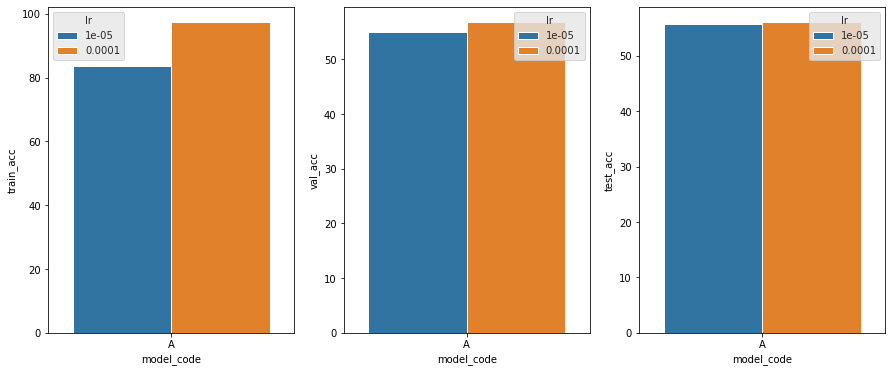

In [15]:
import seaborn as sns 
import matplotlib.pyplot as plt

df = load_exp_result('exp1_lr_model_code')

fig, ax = plt.subplots(1, 3)
fig.set_size_inches(15, 6)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

sns.barplot(x='model_code', y='train_acc', hue='lr', data=df, ax=ax[0])
sns.barplot(x='model_code', y='val_acc', hue='lr', data=df, ax=ax[1])
sns.barplot(x='model_code', y='test_acc', hue='lr', data=df, ax=ax[2])

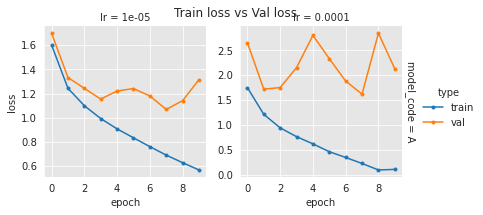

In [16]:

var1 = 'lr'
var2 = 'model_code'

df = load_exp_result('exp1_lr_model_code')
list_v1 = df[var1].unique()
list_v2 = df[var2].unique()
list_data = []

for value1 in list_v1:
    for value2 in list_v2:
        row = df.loc[df[var1]==value1]
        row = row.loc[df[var2]==value2]
        
        train_losses = list(row.train_losses)[0]
        val_losses = list(row.val_losses)[0]
        
        for epoch, train_loss in enumerate(train_losses):
            list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1, var2:value2})
        for epoch, val_loss in enumerate(val_losses):
            list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1, var2:value2})
        
df = pd.DataFrame(list_data)
g = sns.FacetGrid(df, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)
g = g.map(plt.plot, 'epoch', 'loss', marker='.')
g.add_legend()
g.fig.suptitle('Train loss vs Val loss')
plt.subplots_adjust(top=0.89)

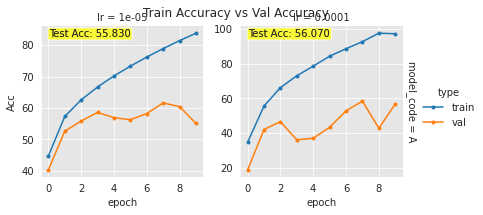

In [17]:
var1 = 'lr'
var2 = 'model_code'

df = load_exp_result('exp1_lr_model_code')
list_v1 = df[var1].unique()
list_v2 = df[var2].unique()
list_data = []

for value1 in list_v1:
    for value2 in list_v2:
        row = df.loc[df[var1]==value1]
        row = row.loc[df[var2]==value2]
        
        train_accs = list(row.train_accs)[0]
        val_accs = list(row.val_accs)[0]
        test_acc = list(row.test_acc)[0]
        
        for epoch, train_acc in enumerate(train_accs):
            list_data.append({'type':'train', 'Acc':train_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
        for epoch, val_acc in enumerate(val_accs):
            list_data.append({'type':'val', 'Acc':val_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
        
df = pd.DataFrame(list_data)
g = sns.FacetGrid(df, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)
g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

def show_acc(x, y, metric, **kwargs):
    plt.scatter(x, y, alpha=0.3, s=1)
    metric = "Test Acc: {:1.3f}".format(list(metric.values)[0])
    plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')

g.add_legend()
g.fig.suptitle('Train Accuracy vs Val Accuracy')



plt.subplots_adjust(top=0.89)